# Predicting future demand

The predict cycle takes as input the model generated in the [data analysis](./data-analysis.ipynb) stage. 

Using the transition rates and new entry rates as well as a starting population, the model iterates day-by-day to see how the population changes over time. 

We start off by calculating our population statistics:

In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import matplotlib.pyplot as pp
from cs_demand_model import Config, DemandModellingDataContainer, ModelPredictor, PopulationStats, fs_datastore

config = Config()
datastore = fs_datastore("sample://v1.zip")
dc = DemandModellingDataContainer(datastore, config)
stats = PopulationStats(dc.enriched_view, config)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Failed to read file DataFile(name='2017/placed_for_adoption.csv', metadata=Metadata(name='placed_for_adoption.csv', size=1, year=2017, table=None)): File is empty
Failed to read file DataFile(name='2017/ad1.csv', metadata=Metadata(name='ad1.csv', size=1, year=2017, table=None)): File is empty
Failed to read file DataFile(name='2019/placed_for_adoption.csv', metadata=Metadata(name='placed_for_adoption.csv', size=1, year=2019, table=None)): File is empty
Failed to read file DataFile(name='2019/ad1.csv', metadata=Metadata(name='ad1.csv', size=1, year=2019, table=None)): File is empty
Failed to read file DataFile(name='2021/placed_for_adoption.csv', metadata=Metadata(name='placed_for_adoption.csv', size=1, year=2021, table=None)): File is empty
Failed to read file DataFile(name='2021/ad1.csv', metadata=Metadata(name='ad1.csv', size=1, year=2021, table=None)): File is empty
Failed to read file DataFile(name='2020/placed_for_adoption.csv', metadata=Metadata(name='placed_for_adoption.csv', si

In [2]:
stats.stock.tail()

bin,"(FIVE_TO_TEN, FOSTERING)","(FIVE_TO_TEN, OTHER)","(FIVE_TO_TEN, RESIDENTIAL)","(SIXTEEN_TO_EIGHTEEN, FOSTERING)","(SIXTEEN_TO_EIGHTEEN, OTHER)","(SIXTEEN_TO_EIGHTEEN, RESIDENTIAL)","(SIXTEEN_TO_EIGHTEEN, SUPPORTED)","(TEN_TO_SIXTEEN, FOSTERING)","(TEN_TO_SIXTEEN, OTHER)","(TEN_TO_SIXTEEN, RESIDENTIAL)","(TEN_TO_SIXTEEN, SUPPORTED)"
date,,,,,,,,,,,
2022-03-23,0.0,0.0,0.0,5.0,2.0,2.0,9.0,49.0,9.0,10.0,0.0
2022-03-24,0.0,0.0,0.0,5.0,2.0,2.0,9.0,49.0,9.0,10.0,0.0
2022-03-25,0.0,0.0,0.0,5.0,2.0,2.0,9.0,50.0,8.0,10.0,0.0
2022-03-26,0.0,0.0,0.0,5.0,2.0,2.0,9.0,50.0,8.0,10.0,0.0
2022-03-27,0.0,0.0,0.0,5.0,2.0,2.0,9.0,50.0,8.0,10.0,0.0


In [3]:
from datetime import date
stats.raw_transition_rates(date(2019,7,1), date(2020,1,1))

start_bin                           end_bin                           
(FIVE_TO_TEN, FOSTERING)            (FIVE_TO_TEN, FOSTERING)              0.002984
                                    (FIVE_TO_TEN, NOT_IN_CARE)            0.000615
                                    (FIVE_TO_TEN, OTHER)                  0.000180
                                    (FIVE_TO_TEN, RESIDENTIAL)            0.000270
(FIVE_TO_TEN, OTHER)                (FIVE_TO_TEN, FOSTERING)              0.000000
                                    (FIVE_TO_TEN, NOT_IN_CARE)            0.000000
                                    (FIVE_TO_TEN, OTHER)                  0.005405
                                    (FIVE_TO_TEN, RESIDENTIAL)            0.000000
(FIVE_TO_TEN, RESIDENTIAL)          (FIVE_TO_TEN, FOSTERING)              0.000000
                                    (FIVE_TO_TEN, NOT_IN_CARE)            0.001351
                                    (FIVE_TO_TEN, OTHER)                  0.000000
                

From this we can now run a model prediction to see how the population evolves. 
As we covered in the data analysis documentation, we need to provide a start and end date for the analysis window.

In [4]:
start_date, end_date = pd.to_datetime('2019-07-01'), pd.to_datetime('2020-01-01')
predictor = ModelPredictor.from_model(stats, start_date, end_date)

The predictor is an iterative model that has a state and can return the predictor for the next period. 

To see the current population, in this case the starting population from the model, view the `initial_population`:

In [5]:
predictor.initial_population

bin
(FIVE_TO_TEN, FOSTERING)               23.0
(FIVE_TO_TEN, OTHER)                    0.0
(FIVE_TO_TEN, RESIDENTIAL)              3.0
(SIXTEEN_TO_EIGHTEEN, FOSTERING)        9.0
(SIXTEEN_TO_EIGHTEEN, OTHER)            7.0
(SIXTEEN_TO_EIGHTEEN, RESIDENTIAL)      1.0
(SIXTEEN_TO_EIGHTEEN, SUPPORTED)       14.0
(TEN_TO_SIXTEEN, FOSTERING)           130.0
(TEN_TO_SIXTEEN, OTHER)                23.0
(TEN_TO_SIXTEEN, RESIDENTIAL)          31.0
(TEN_TO_SIXTEEN, SUPPORTED)             0.0
Name: 2020-01-01 00:00:00, dtype: float64

In [6]:
predictor.transition_rates

from                           to                              
(BIRTH_TO_ONE, FOSTERING)      (ONE_TO_FIVE, FOSTERING)            0.002740
(BIRTH_TO_ONE, NOT_IN_CARE)    (ONE_TO_FIVE, NOT_IN_CARE)          0.002740
(BIRTH_TO_ONE, OTHER)          (ONE_TO_FIVE, OTHER)                0.002740
(BIRTH_TO_ONE, RESIDENTIAL)    (ONE_TO_FIVE, RESIDENTIAL)          0.002740
(BIRTH_TO_ONE, SUPPORTED)      (ONE_TO_FIVE, SUPPORTED)            0.002740
                                                                     ...   
(TEN_TO_SIXTEEN, RESIDENTIAL)  (TEN_TO_SIXTEEN, RESIDENTIAL)       0.002195
                               (TEN_TO_SIXTEEN, SUPPORTED)         0.000000
(TEN_TO_SIXTEEN, SUPPORTED)    (SIXTEEN_TO_EIGHTEEN, SUPPORTED)    0.000457
                               (TEN_TO_SIXTEEN, FOSTERING)         0.005405
                               (TEN_TO_SIXTEEN, NOT_IN_CARE)       0.000000
Length: 74, dtype: float64

In [7]:
tn, tr = predictor.transition_numbers.align(predictor.transition_rates)
tn.fillna(0) + tr.fillna(0)

from                           to                              
()                             (FIVE_TO_TEN, FOSTERING)            0.005435
                               (TEN_TO_SIXTEEN, FOSTERING)         0.021739
(BIRTH_TO_ONE, FOSTERING)      (ONE_TO_FIVE, FOSTERING)            0.002740
(BIRTH_TO_ONE, NOT_IN_CARE)    (ONE_TO_FIVE, NOT_IN_CARE)          0.002740
(BIRTH_TO_ONE, OTHER)          (ONE_TO_FIVE, OTHER)                0.002740
                                                                     ...   
(TEN_TO_SIXTEEN, RESIDENTIAL)  (TEN_TO_SIXTEEN, RESIDENTIAL)       0.002195
                               (TEN_TO_SIXTEEN, SUPPORTED)         0.000000
(TEN_TO_SIXTEEN, SUPPORTED)    (SIXTEEN_TO_EIGHTEEN, SUPPORTED)    0.000457
                               (TEN_TO_SIXTEEN, FOSTERING)         0.005405
                               (TEN_TO_SIXTEEN, NOT_IN_CARE)       0.000000
Length: 76, dtype: float64

We can now ask for the next population:

In [8]:
predictor = predictor.next()
predictor.initial_population

from
(BIRTH_TO_ONE, FOSTERING)               0.000000
(BIRTH_TO_ONE, NOT_IN_CARE)             0.000000
(BIRTH_TO_ONE, OTHER)                   0.000000
(BIRTH_TO_ONE, RESIDENTIAL)             0.000000
(BIRTH_TO_ONE, SUPPORTED)               0.000000
(FIVE_TO_TEN, FOSTERING)               22.968327
(FIVE_TO_TEN, NOT_IN_CARE)              0.018195
(FIVE_TO_TEN, OTHER)                    0.004144
(FIVE_TO_TEN, RESIDENTIAL)              3.000522
(FIVE_TO_TEN, SUPPORTED)                0.000000
(ONE_TO_FIVE, FOSTERING)                0.000000
(ONE_TO_FIVE, NOT_IN_CARE)              0.000000
(ONE_TO_FIVE, OTHER)                    0.000000
(ONE_TO_FIVE, RESIDENTIAL)              0.000000
(ONE_TO_FIVE, SUPPORTED)                0.000000
(SIXTEEN_TO_EIGHTEEN, FOSTERING)        9.044208
(SIXTEEN_TO_EIGHTEEN, NOT_IN_CARE)      0.074696
(SIXTEEN_TO_EIGHTEEN, OTHER)            6.995634
(SIXTEEN_TO_EIGHTEEN, RESIDENTIAL)      1.008554
(SIXTEEN_TO_EIGHTEEN, SUPPORTED)       13.954860
(TEN_TO_SIXTEEN

You can run the above block multiple times to see the population change. To reset, go back and create a new predictor from the initial state. 

Since we usually want to run multiple iterations in one simple operations, there is also a utility method on the predictor to run *n* generations and return a dataframe of all the populations. You can add progress=True to get a progress bar so you have something to enjoy watching while you make a cup of tea...

In [9]:
start_date, end_date = pd.to_datetime('2017-07-01'), pd.to_datetime('2017-10-01')

predictor = ModelPredictor.from_model(stats, start_date, end_date)
predicted_pop = predictor.predict(72, progress=True, step_days=10)  # Predict 720 days forward

historic_pop = stats.stock.loc[:end_date]

predicted_pop, historic_pop = predicted_pop.align(historic_pop, axis=1, fill_value=0)
combined_pop = pd.concat([historic_pop, predicted_pop], axis=0)
combined_pop.columns = pd.MultiIndex.from_tuples(combined_pop.columns)
combined_pop

2019-09: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 72/72 [00:01<00:00, 57.64it/s]


BIRTH_TO_ONE                                         FIVE_TO_TEN  \
              FOSTERING NOT_IN_CARE OTHER RESIDENTIAL SUPPORTED   FOSTERING   
2013-08-27          0.0         0.0   0.0         0.0       0.0    0.000000   
2013-08-28          0.0         0.0   0.0         0.0       0.0    0.000000   
2013-08-29          0.0         0.0   0.0         0.0       0.0    0.000000   
2013-08-30          0.0         0.0   0.0         0.0       0.0    0.000000   
2013-08-31          0.0         0.0   0.0         0.0       0.0    0.000000   
...                 ...         ...   ...         ...       ...         ...   
2019-08-12          0.0         0.0   0.0         0.0       0.0  106.315373   
2019-08-22          0.0         0.0   0.0         0.0       0.0  106.093187   
2019-09-01          0.0         0.0   0.0         0.0       0.0  105.875173   
2019-09-11          0.0         0.0   0.0         0.0       0.0  105.661245   
2019-09-21          0.0         0.0   0.0         0.0       0.0  105.451319   

                                                         ...  \
           NOT_IN_CARE      OTHER RESIDENTIAL SUPPORTED  ...   
2013-08-27    0.000000   1.000000    0.000000       0.0  ...   
2013-08-28    0.000000   1.000000    0.000000       0.0  ...   
2013-08-29    0.000000   1.000000    0.000000       0.0  ...   
2013-08-30    0.000000   1.000000    0.000000       0.0  ...   
2013-08-31    0.000000   1.000000    0.000000       0.0  ...   
...                ...        ...         ...       ...  ...   
2019-08-12   70.081949  30.034549   22.745765       0.0  ...   
2019-08-22   70.835863  30.132826   22.710909       0.0  ...   
2019-09-01   71.583488  30.229679   22.676341       0.0  ...   
2019-09-11   72.324892  30.325130   22.642077       0.0  ...   
2019-09-21   73.060144  30.419196   22.608128       0.0  ...   

           SIXTEEN_TO_EIGHTEEN                                                \
                     FOSTERING NOT_IN_CARE      OTHER RESIDENTIAL  SUPPORTED   
2013-08-27            0.000000    0.000000   0.000000    0.000000   0.000000   
2013-08-28            0.000000    0.000000   0.000000    0.000000   0.000000   
2013-08-29            0.000000    0.000000   0.000000    0.000000   0.000000   
2013-08-30            0.000000    0.000000   0.000000    0.000000   0.000000   
2013-08-31            0.000000    0.000000   0.000000    0.000000   0.000000   
...                        ...         ...        ...         ...        ...   
2019-08-12           49.427136  122.036760  16.917937    2.103501  12.524211   
2019-08-22           49.551983  124.108693  16.959456    2.090727  12.511568   
2019-09-01           49.672083  126.188616  16.999867    2.078354  12.501231   
2019-09-11           49.787568  128.276462  17.039190    2.066369  12.493093   
2019-09-21           49.898567  130.372162  17.077445    2.054758  12.487053   

           TEN_TO_SIXTEEN                                                
                FOSTERING NOT_IN_CARE      OTHER RESIDENTIAL  SUPPORTED  
2013-08-27       0.000000    0.000000   0.000000    0.000000   0.000000  
2013-08-28       0.000000    0.000000   0.000000    0.000000   0.000000  
2013-08-29       0.000000    0.000000   0.000000    0.000000   0.000000  
2013-08-30       0.000000    0.000000   0.000000    0.000000   0.000000  
2013-08-31       0.000000    0.000000   0.000000    0.000000   0.000000  
...                   ...         ...        ...         ...        ...  
2019-08-12     219.112131  184.401041  50.042204   20.190858  27.417698  
2019-08-22     218.639313  186.640096  50.041452   20.139326  27.716175  
2019-09-01     218.174146  188.868179  50.039018   20.089153  28.012379  
2019-09-11     217.716505  191.085377  50.034981   20.040284  28.306334  
2019-09-21     217.266262  193.291773  50.029418   19.992670  28.598065  

[1569 rows x 25 columns]

In [10]:
# Combine age groups so we only see by care type
by_care_type = combined_pop.groupby(level=1, axis=1).sum()
by_care_type

,FOSTERING,NOT_IN_CARE,OTHER,RESIDENTIAL,SUPPORTED
2013-08-27,0.000000,0.000000,1.000000,0.000000,0.000000
2013-08-28,0.000000,0.000000,1.000000,0.000000,0.000000
2013-08-29,0.000000,0.000000,1.000000,0.000000,0.000000
2013-08-30,0.000000,0.000000,1.000000,0.000000,0.000000
2013-08-31,0.000000,0.000000,1.000000,0.000000,0.000000
...,...,...,...,...,...
2019-08-12,374.854640,376.519750,96.994690,45.040124,39.941909
2019-08-22,374.284482,381.584651,97.133734,44.940962,40.227744
2019-09-01,373.721402,386.640283,97.268565,44.843848,40.513610
2019-09-11,373.165318,391.686732,97.399301,44.748730,40.799427


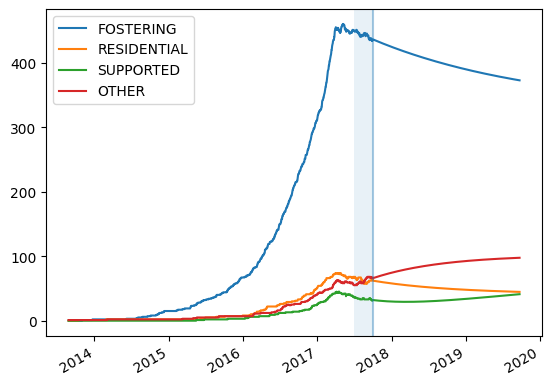

In [11]:
# Combine age groups so we only see 

by_care_type[['FOSTERING', 'RESIDENTIAL', 'SUPPORTED', 'OTHER']].plot.line(legend=True)
pp.axvline(end_date, alpha=0.4)
pp.axvspan(start_date, end_date, alpha=0.1)
pp.show()